In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../../data/'
fy15 = read_csv(path+"2015_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy15 = fy15.rename(columns={"Value (KW)":"kw", "eDNA Status as String":"status"})

fy16 = read_csv(path+"2016_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy16 = fy16.rename(columns={"Value (KW)":"kw", "eDNA Status as String":"status"})

fy17 = read_csv(path+"2017_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy17 = fy17.rename(columns={"Value (KW)":"kw", "eDNA Status as String":"status"})

fy18 = read_csv(path+"2018_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy18 = fy18.rename(columns={"Value (KW)":"kw", "eDNA Status as String":"status"})

fy19 = read_csv(path+"2019_uiuc_electricity_demand.csv", 
                    skiprows=1, 
                    parse_dates=True, 
                    index_col = ['Date and Time'])
fy19 = fy19.rename(columns={"Value (KW)":"kw", "eDNA Status as String":"status"})

## Combine Datasets

In [3]:
frames = [fy15, fy16, fy17, fy18, fy19]
time_series = pd.concat(frames)
# time_series.time = time_series.index
time_series

,kw,status
Date and Time,,
2014-07-01 00:00:00,61731.0,OK
2014-07-01 01:00:00,60009.0,OK
2014-07-01 02:00:00,58725.0,OK
2014-07-01 03:00:00,58282.0,OK
2014-07-01 04:00:00,58684.0,OK
...,...,...
2019-06-30 19:00:00,55136.0,OK
2019-06-30 20:00:00,54423.0,OK
2019-06-30 21:00:00,57478.0,OK


In [4]:
mask = time_series['status'] == 'UNRELIABLE'
time_series[mask]

,kw,status
Date and Time,,
2014-10-21 16:00:00,0.000,UNRELIABLE
2014-10-21 17:00:00,0.000,UNRELIABLE
2014-10-21 18:00:00,0.000,UNRELIABLE
2014-10-21 19:00:00,0.000,UNRELIABLE
2014-10-21 20:00:00,0.000,UNRELIABLE
...,...,...
2016-04-29 11:00:00,55176.523,UNRELIABLE
2016-05-24 12:00:00,43617.027,UNRELIABLE
2016-06-02 12:00:00,58510.026,UNRELIABLE


#### Check "unreliable" data

In [5]:
time_series_hours = time_series.copy()
time_series_hours['time'] = time_series_hours.index
time_series_hours
time_series_hours_unreliable = time_series_hours[mask]

In [6]:
time_series_hours

,kw,status,time
Date and Time,,,
2014-07-01 00:00:00,61731.0,OK,2014-07-01 00:00:00
2014-07-01 01:00:00,60009.0,OK,2014-07-01 01:00:00
2014-07-01 02:00:00,58725.0,OK,2014-07-01 02:00:00
2014-07-01 03:00:00,58282.0,OK,2014-07-01 03:00:00
2014-07-01 04:00:00,58684.0,OK,2014-07-01 04:00:00
...,...,...,...
2019-06-30 19:00:00,55136.0,OK,2019-06-30 19:00:00
2019-06-30 20:00:00,54423.0,OK,2019-06-30 20:00:00
2019-06-30 21:00:00,57478.0,OK,2019-06-30 21:00:00


/home/dotson/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


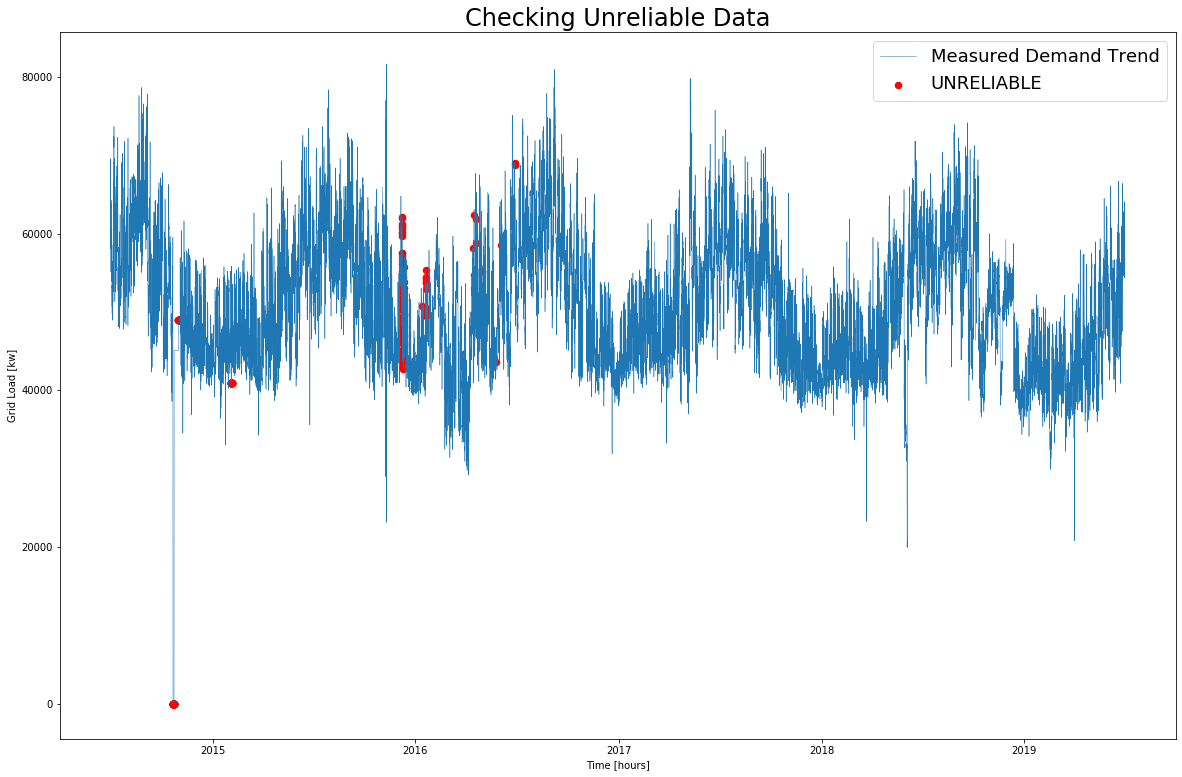

In [7]:
fig = plt.figure(figsize=(20,13), facecolor='w')
trend = plt.plot(time_series_hours['time'], time_series_hours['kw'], lw=0.5, label="Measured Demand Trend")

legend = True
for hour, power in zip(list(time_series_hours_unreliable['time'].values), 
                       list(time_series_hours_unreliable['kw'].values)):
  if legend:
    # I only want it to show up on the legend once
    plt.scatter(hour, power, color='r',marker='o', linewidths=1.5,label='UNRELIABLE')
    legend = False
  else:
    plt.scatter(hour, power, color='r',marker='o', linewidths=1.5)



plt.legend(fontsize=18)
plt.title('Checking Unreliable Data', fontsize=24)
plt.xlabel('Time [hours]')
plt.ylabel('Grid Load [kw]')
plt.show()

#### Based on the above graph, the "unreliable" data seems to be mostly false positives. 

Except for the 0 demand in 2014, which won't be included anyway because we can only use years we have complete datasets for... 

## Separate by year and pass to RAVEN

In [8]:
%%capture

grouped = time_series.groupby(time_series.index.year)

df15 = grouped.get_group(2015)
df16 = grouped.get_group(2016)[:8760] # must be same length as other years
df17 = grouped.get_group(2017)
df18 = grouped.get_group(2018)

df15.reset_index(inplace=True)
df16.reset_index(inplace=True)
df18.reset_index(inplace=True)
df17.reset_index(inplace=True)

df18['time'] = df18.index
df17['time'] = df17.index
df16['time'] = df16.index
df15['time'] = df15.index

df18 = df18[['time','kw']]
df17 = df17[['time','kw']]
df16 = df16[['time','kw']]
df15 = df15[['time','kw']]

In [9]:
df15

,time,kw
0,0,41903.0
1,1,43479.0
2,2,43572.0
3,3,43253.0
4,4,43566.0
...,...,...
8755,8755,43157.0
8756,8756,42881.0
8757,8757,42259.0
8758,8758,42260.0


In [10]:
# writes the header file for RAVEN
fname = 'annual_load201'
keys = [fname + str(i) + '.csv' for i in range(5,9,1)]
header_file = pd.DataFrame({'n':np.zeros(len(keys), dtype=np.int8), 'filename':keys})
header_file.to_csv(path+'annual_load_H.csv')
print(keys)

['annual_load2015.csv', 'annual_load2016.csv', 'annual_load2017.csv', 'annual_load2018.csv']


In [11]:
df15.to_csv(path+'annual_load2015.csv')
df16.to_csv(path+'annual_load2016.csv')
df17.to_csv(path+'annual_load2017.csv')
df18.to_csv(path+'annual_load2018.csv')

## RAVEN

In [12]:
!ls ~/Research/data/

2014_2019_uiuc_electricity_demand.csv  __MACOSX
2015_uiuc_electricity_demand.csv       solardata_2015.csv
2016_uiuc_electricity_demand.csv       solardata_2016.csv
2017_uiuc_electricity_demand.csv       solardata_2017.csv
2018_uiuc_electricity_demand.csv       solardata_2018.csv
2019_uiuc_electricity_demand.csv       solardata_2019.csv
annual_load2015.csv		       solardata.csv
annual_load2016.csv		       solar_farm_data
annual_load2017.csv		       solar_model_data
annual_load2018.csv		       steam_data
annual_load_H.csv		       steamfy15.csv
annual_steam2015.csv		       steamfy16.csv
annual_steam2016.csv		       steamfy17.csv
annual_steam2017.csv		       steamfy18.csv
annual_steam2018.csv		       steamfy19.csv
annual_steam_H.csv		       TypicalDemand_0.csv
dni_2012.csv			       TypicalDemand.csv
dni_2013.csv			       TypicalDemand.xml
dni_2014.csv			       TypicalSolar_0.csv
dni_2015.csv			       TypicalSolar.csv
dni_2016.csv			       TypicalSolar.xml
dni_2017.csv			       TypicalSteam

In [13]:
!~/Research/raven/raven_framework ~/Research/2020-dotson-optimal-sizing/inputfiles/typical_demand.xml

CONDA
raven_libraries          /home/dotson/anaconda3/envs/raven_libraries
Running RAVEN in "opt" mode.
/home/dotson/Research/raven/framework/utils/utils.py:579: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp, os.path
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/home/dotson/anaconda3/envs/raven_libraries/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'colle

(    0.03 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/annual_load2017.csv.csv"
(    0.04 sec) HistorySet               : DEBUG           -> Reading data from "/home/dotson/Research/data/annual_load2018.csv.csv"
(    0.05 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.05 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    0.05 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    0.05 sec) SIMULATION               : Message         -> -- End step read of type: IOStep                               --

(    0.05 sec) SIMULATION               : Message         -> -- Beginning step get_history of type: PostProcess                  --
(    0.05 sec) STEP SINGLERUN           : Message         -> ***  Beginning initialization ***
(    0.05 sec) STEP SINGLERUN           : DEBUG           -> jobHandler initialized
(    0.05 se

(    0.21 sec) HistorySet               : DEBUG           -> Printing metadata XML: "TypicalDemand.xml"
(    0.21 sec) STEP IOCOMBINED          : Message         -> ***       Run finished        ***
(    0.21 sec) STEP IOCOMBINED          : Message         -> ***     Closing the step      ***
(    0.21 sec) STEP IOCOMBINED          : Message         -> ***        Step closed        ***
(    0.21 sec) SIMULATION               : Message         -> -- End step write of type: IOStep                              --

--------------------------------------------------
There were 1 warnings during the simulation run:
(1 time) DataObject._convertToDict can be a slow operation and should be avoided where possible!
--------------------------------------------------
(    0.21 sec) SIMULATION               : Message         -> Run complete!


In [14]:
typical_demand = pd.read_csv(path+"TypicalDemand_0.csv")

typical_demand['date'] = pd.date_range(start='1/1/2018', end='1/1/2019', freq='H')[:8760]

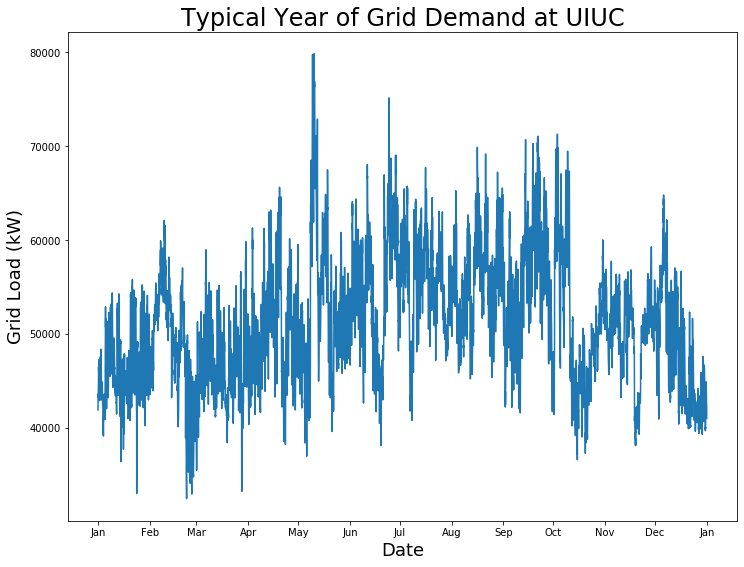

In [15]:
import matplotlib.dates as mdates


# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

fig = plt.figure(figsize=(12,9), edgecolor='k', facecolor='w')
plt.plot(typical_demand.date, typical_demand.kw)
plt.title('Typical Year of Grid Demand at UIUC', fontsize=24)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Grid Load (kW)',fontsize=18)

X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.show()
